In [497]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [498]:
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
submission = pd.read_csv('../Data/sample_submission.csv')
sub_train = train

# Feature 설명

index   
gender: 성별   
car: 차량 소유 여부   
reality: 부동산 소유 여부   
child_num: 자녀 수   
income_total: 연간 소득  
income_type: 소득 분류 
['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']   
edu_type: 교육 수준   
['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']   
family_type: 결혼 여부   
['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']   
house_type: 생활 방식   
['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']   
DAYS_BIRTH: 출생일   
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미   
DAYS_EMPLOYED: 업무 시작일   
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미,양수 값은 고용되지 않은 상태를 의미함   
FLAG_MOBIL: 핸드폰 소유 여부  
work_phone: 업무용 전화 소유 여부   
phone: 전화 소유 여부  
email: 이메일 소유 여부   
occyp_type: 직업 유형	   												
family_size: 가족 규모  
begin_month: 신용카드 발급 월 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미
credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도   
=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함   



# DEF 모음

In [499]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [500]:
def box_value(col):
    Q1 = abs(train[train[col] > 0][col].quantile(0.25))
    Q2 = abs(train[train[col] > 0][col].quantile(0.50))
    Q3 = abs(train[train[col] > 0][col].quantile(0.75))
    IQR = Q3 - Q1

    return Q1, Q2, Q3, IQR

# Preprocessing

## **0. FLAG_MOBIL**

In [501]:
train['FLAG_MOBIL'] = train['FLAG_MOBIL'] - train['work_phone']*0.3 - train['phone']*0.3 - train['email']*0.3
test['FLAG_MOBIL'] = test['FLAG_MOBIL'] - test['work_phone']*0.3 - test['phone']*0.3 - test['email']*0.3

In [502]:
train['FLAG_MOBIL'] = train['FLAG_MOBIL'].replace([1,0.7,0.39999999999999997,0.09999999999999998], ['A','B','C','D'])
test['FLAG_MOBIL'] = test['FLAG_MOBIL'].replace([1,0.7,0.39999999999999997,0.09999999999999998], ['A','B','C','D'])

In [503]:
train['FLAG_MOBIL'].value_counts()

A    14542
B     7962
C     3675
D      278
Name: FLAG_MOBIL, dtype: int64

In [504]:
test['FLAG_MOBIL'].value_counts()

A    5502
B    2984
C    1431
D      83
Name: FLAG_MOBIL, dtype: int64

## **1. DAYS_EMPLOYED**

In [505]:
train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].value_counts()

365243    4438
Name: DAYS_EMPLOYED, dtype: int64

In [506]:
train.loc[train['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0
test.loc[test['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0

<AxesSubplot:ylabel='Frequency'>

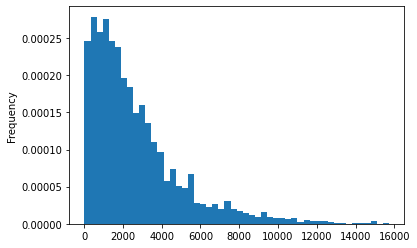

In [507]:
abs(train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED']).plot(kind='hist',bins=50,density=True)

In [508]:
train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'].abs()
test.loc[test['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = test.loc[test['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'].abs()
train['DAYS_EMPLOYED']

0        4709
1        1540
2        4434
3        2092
4        2105
         ... 
26452    1984
26453    2475
26454    2015
26455     107
26456    1013
Name: DAYS_EMPLOYED, Length: 26457, dtype: int64

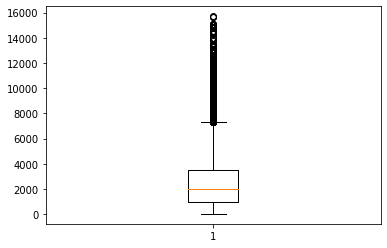

In [509]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [510]:
Q1 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.25))
Q2 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.50))
Q3 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.75))
IQR = Q3 - Q1

print(f'Q1 : {Q1} Q3 : {Q3} IQR : {IQR}')

Q1 : 969.5 Q3 : 3506.0 IQR : 2536.5


In [511]:
train.loc[(train['DAYS_EMPLOYED'] <= Q1 - 1.5 * IQR) | (train['DAYS_EMPLOYED'] >= Q3 + 1.5 *IQR), 'DAYS_EMPLOYED'] = Q3
test.loc[(test['DAYS_EMPLOYED'] <= Q1 - 1.5 * IQR) | (test['DAYS_EMPLOYED'] >= Q3 + 1.5 *IQR), 'DAYS_EMPLOYED'] = Q3

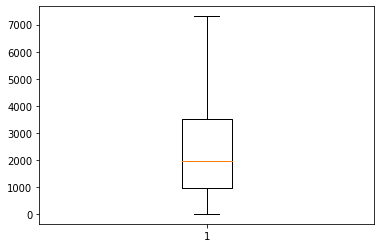

In [512]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [513]:
def dayEMP_category(day_ep):
    ep = ''
    if day_ep == 0: ep = 0
    elif day_ep <= Q1: ep = 1
    elif day_ep <= Q2: ep = 2
    elif day_ep <= Q3: ep = 3
    elif day_ep > Q3: ep = 4
       
    return ep


In [514]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x : dayEMP_category(x))
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(lambda x : dayEMP_category(x))

In [515]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D', 4 : 'E'})
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D', 4 : 'E'})

In [516]:
train['DAYS_EMPLOYED'].value_counts()

D    6763
C    5506
B    5505
A    4438
E    4245
Name: DAYS_EMPLOYED, dtype: int64

## Begin_month

<AxesSubplot:ylabel='Frequency'>

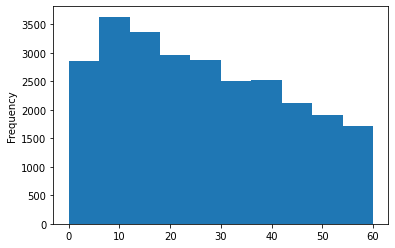

In [517]:
abs(train['begin_month']).plot(kind='hist', bins = 10)

In [518]:
train['begin_month'] = train['begin_month'].abs()
test['begin_month'] = test['begin_month'].abs()

In [519]:
begin_catagory = [0,1,1,2,2,3,3,4,4,4]
train['begin_month'] = pd.cut(train['begin_month'], bins = 10, labels= begin_catagory, ordered= False)
test['begin_month'] = pd.cut(test['begin_month'], bins = 10, labels= begin_catagory, ordered= False)

In [520]:
train['begin_month'] = train['begin_month'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D', 4 : 'E'})
test['begin_month'] = test['begin_month'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D', 4 : 'E'})

In [521]:
train['begin_month'].value_counts()

B    6911
C    5773
E    5362
D    4965
A    3446
Name: begin_month, dtype: int64

## income_total

<AxesSubplot:ylabel='Frequency'>

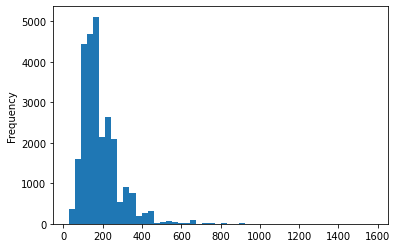

In [522]:
(train['income_total']/1000).plot(kind = 'hist', bins = 50)

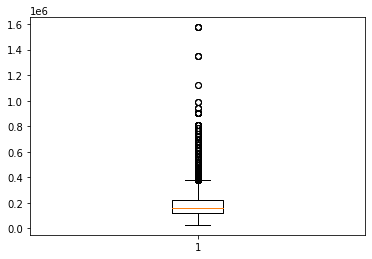

In [523]:
plt.boxplot(train['income_total'])
plt.show()

In [524]:
Q1 = box_value('income_total')[0]
Q2 = box_value('income_total')[1]
Q3 = box_value('income_total')[2]
IQR = box_value('income_total')[3]

In [525]:
train.loc[(train['income_total'] <= Q1 - 1.5 * IQR) | (train['income_total'] >= Q3 + 1.5 *IQR), 'income_total'] = Q3 + IQR/3
test.loc[(test['income_total'] <= Q1 - 1.5 * IQR) | (test['income_total'] >= Q3 + 1.5 *IQR), 'income_total'] = Q3 + IQR/3

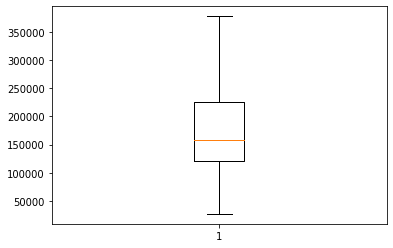

In [526]:
plt.boxplot(train['income_total'])
plt.show()

In [527]:
def box_category(value):
    ep = ''
    if value <= Q1: ep = 0
    elif value <= Q2: ep = 1
    elif value <= Q3: ep = 2
    elif value > Q3: ep = 3
       
    return ep

In [528]:
train['income_total'] = train['income_total'].apply(lambda x : box_category(x))
test['income_total'] = test['income_total'].apply(lambda x : box_category(x))

In [529]:
train['income_total'] = train['income_total'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D'})
test['income_total'] = test['income_total'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D'})

In [530]:
train['income_total'].value_counts()

C    7334
A    6751
B    6685
D    5687
Name: income_total, dtype: int64

## Gender, Car, Reality

In [531]:
""" train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------') """

" train['gender'] = train['gender'].replace(['F','M'],[0,1])\ntest['gender'] = test['gender'].replace(['F','M'],[0,1])\nprint('gender :')\nprint(train['gender'].value_counts())\nprint('--------------')\n\nprint('Having a car or not : ')\ntrain['car'] = train['car'].replace(['N','Y'],[0,1])\ntest['car'] = test['car'].replace(['N','Y'],[0,1])\nprint(train['car'].value_counts())\nprint('--------------')\n\nprint('Having house reality or not: ')\ntrain['reality'] = train['reality'].replace(['N','Y'],[0,1])\ntest['reality'] = test['reality'].replace(['N','Y'],[0,1])\nprint(train['reality'].value_counts())\nprint('--------------') "

## DAYS_BIRTH

In [532]:
train['DAYS_BIRTH'] = (train['DAYS_BIRTH'].abs()/365).astype(int)
test['DAYS_BIRTH'] = (test['DAYS_BIRTH'].abs()/365).astype(int)

<AxesSubplot:ylabel='Frequency'>

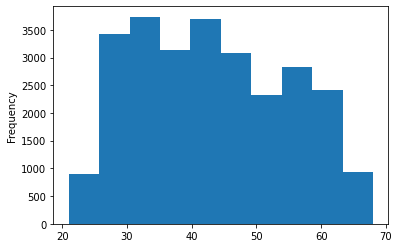

In [533]:
train['DAYS_BIRTH'].plot(kind='hist')

In [534]:
def birth_catagory(value):
    ep = ''
    if value <= 30: ep = 'A'
    elif value <= 40: ep = 'B'
    elif value <= 50: ep = 'C'
    elif value <= 60: ep = 'D'
    elif value < 70: ep = 'E'
       
    return ep

In [535]:
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(lambda x : birth_catagory(x))
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(lambda x : birth_catagory(x))

In [536]:
train['DAYS_BIRTH'].value_counts()

B    7689
C    6542
D    5730
A    4324
E    2172
Name: DAYS_BIRTH, dtype: int64

## family_size

In [537]:
train['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [538]:
test['family_size'].value_counts()

2.0    5357
1.0    1878
3.0    1789
4.0     846
5.0     106
6.0      14
7.0      10
Name: family_size, dtype: int64

In [539]:
train['family_size'] = train['family_size'].replace([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 4)
test['family_size'] = test['family_size'].replace([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 4)

In [540]:
train['family_size'] = train['family_size'].replace({1 : 'A', 2 : 'B', 3 : 'C', 4 : 'D'})
test['family_size'] = test['family_size'].replace({1 : 'A', 2 : 'B', 3 : 'C', 4 : 'D'})

In [541]:
train['family_size'].value_counts()

B    14106
A     5109
C     4632
D     2610
Name: family_size, dtype: int64

## work_phone, phone, email, FLAG_MOBIL

In [542]:
train['work_phone'] = train['work_phone'].replace([0,1], ['N','Y'])
test['work_phone'] = test['work_phone'].replace([0,1], ['N','Y'])
print('work_phone :')
print(train['work_phone'].value_counts())
print('--------------')

train['phone'] = train['phone'].replace([0,1], ['N','Y'])
test['phone'] = test['phone'].replace([0,1], ['N','Y'])
print(train['phone'].value_counts())
print('--------------')


train['email'] = train['email'].replace([0,1], ['N','Y'])
test['email'] = test['email'].replace([0,1], ['N','Y'])
print(train['email'].value_counts())
print('--------------')


work_phone :
N    20511
Y     5946
Name: work_phone, dtype: int64
--------------
N    18672
Y     7785
Name: phone, dtype: int64
--------------
N    24042
Y     2415
Name: email, dtype: int64
--------------


## child_num

In [543]:
train['child_num'].value_counts()

0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64

In [544]:
test['child_num'].value_counts()

0    6861
1    2106
2     894
3     113
4      16
5      10
Name: child_num, dtype: int64

In [545]:
def child_category(value):
    ep = ''
    if value == 0: ep = 'Z'
    elif value == 1: ep = 'O'
    elif value == 2: ep = 'T'
    elif value >= 3: ep = 'M'
    
    return ep

In [546]:
train['child_num'] = train['child_num'].apply(lambda x : child_category(x))
test['child_num'] = test['child_num'].apply(lambda x : child_category(x))

In [547]:
train['child_num'].value_counts()

Z    18340
O     5386
T     2362
M      369
Name: child_num, dtype: int64

## **occyp_type**

In [548]:
""" train = train.drop('occyp_type', axis=1)
test = test.drop('occyp_type', axis=1) """

" train = train.drop('occyp_type', axis=1)\ntest = test.drop('occyp_type', axis=1) "

In [549]:
from sklearn.cluster import KMeans

train['occyp_type'] = train['occyp_type'].fillna('Secret')
test['occyp_type'] = test['occyp_type'].fillna('Secret')

subset = pd.crosstab(train['occyp_type'] , train['income_total'])
subset['Total'] = subset.sum(axis=1)

subset = subset.div(subset['Total'].values, axis = 0)
subset = subset.drop('Total', axis = 1)
subset = subset.drop('Secret', axis = 0)

kmeans = KMeans(n_clusters= 3)
kmeans.fit(subset)

kmeans.labels_

array([0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 1, 0, 2, 0, 2])

In [550]:
subset['cluster'] = kmeans.labels_
subset

income_total,A,B,C,D,cluster
occyp_type,,,,,
Accountants,0.203991,0.266075,0.271619,0.258315,0
Cleaning staff,0.339950,0.280397,0.305211,0.074442,2
Cooking staff,0.422319,0.308534,0.181619,0.087527,2
Core staff,0.225246,0.251701,0.301209,0.221844,0
Drivers,0.130159,0.221587,0.360000,0.288254,0
HR staff,0.145161,0.419355,0.258065,0.177419,0
High skill tech staff,0.180769,0.248077,0.322115,0.249038,0
IT staff,0.170732,0.268293,0.365854,0.195122,0
Laborers,0.217863,0.281472,0.302527,0.198138,0


In [551]:
subset[subset['cluster']== 0].index

Index(['Accountants', 'Core staff', 'Drivers', 'HR staff',
       'High skill tech staff', 'IT staff', 'Laborers',
       'Private service staff', 'Sales staff', 'Security staff'],
      dtype='object', name='occyp_type')

In [552]:
train['occyp_type'] = train['occyp_type'].replace('Secret' , 'A')
train['occyp_type'] = train['occyp_type'].replace(['Accountants', 'Core staff', 'Drivers', 'HR staff','High skill tech staff', 'IT staff', 'Laborers','Private service staff', 'Sales staff', 'Security staff'],
 'B')
train['occyp_type'] = train['occyp_type'].replace(['Cooking staff', 'Cleaning staff','Low-skill Laborers', 'Medicine staff', 'Secretaries','Waiters/barmen staff'], 'C')
train['occyp_type'] = train['occyp_type'].replace(['Realty agents','Managers'], 'D')

In [553]:
test['occyp_type'] = test['occyp_type'].replace('Secret' , 'A')
test['occyp_type'] = test['occyp_type'].replace(['Accountants', 'Core staff', 'Drivers', 'HR staff','High skill tech staff', 'IT staff', 'Laborers','Private service staff', 'Sales staff', 'Security staff'],
 'B')
test['occyp_type'] = test['occyp_type'].replace(['Cooking staff', 'Cleaning staff','Low-skill Laborers', 'Medicine staff', 'Secretaries','Waiters/barmen staff'], 'C')
test['occyp_type'] = test['occyp_type'].replace(['Realty agents','Managers'], 'D')

In [554]:
train['occyp_type'].value_counts()

B    13984
A     8171
D     2230
C     2072
Name: occyp_type, dtype: int64

In [555]:
test['occyp_type'].value_counts()

B    5146
A    3152
D     861
C     841
Name: occyp_type, dtype: int64

In [556]:
train.to_csv('train_2.csv')
test.to_csv('test_2.csv')

## 중간시작

In [672]:
train = pd.read_csv('train_2.csv', index_col = 'Unnamed: 0')
test = pd.read_csv('test_2.csv', index_col = 'Unnamed: 0')

In [673]:
train.head(5)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,Z,C,Commercial associate,Higher education,Married,Municipal apartment,B,E,A,N,N,N,A,B,A,1.0
1,1,F,N,Y,O,D,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,B,C,B,N,N,Y,B,C,A,1.0
2,2,M,Y,Y,Z,D,Working,Higher education,Married,House / apartment,D,E,B,N,Y,N,D,B,C,2.0
3,3,F,N,Y,Z,C,Commercial associate,Secondary / secondary special,Married,House / apartment,C,D,B,N,Y,N,B,B,D,0.0
4,4,F,Y,Y,Z,B,State servant,Higher education,Married,House / apartment,C,D,A,N,N,N,D,B,C,2.0


In [657]:
from sklearn.preprocessing import OrdinalEncoder

## 원핫인코딩

In [658]:
encoder = OrdinalEncoder()


In [668]:
train_x=train.drop(['credit','index'], axis=1)
train_y=train[['credit']]
test_x=test.drop('index', axis =1)

In [669]:
train_x.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type',
       'family_size', 'begin_month'],
      dtype='object')

In [670]:
train_x[['income_total','DAYS_BIRTH','child_num','DAYS_EMPLOYED','family_size']]

,income_total,DAYS_BIRTH,child_num,DAYS_EMPLOYED,family_size
0,C,B,Z,E,B
1,D,B,O,C,C
2,D,D,Z,E,B
3,C,C,Z,D,B
4,B,C,Z,D,B
...,...,...,...,...,...
26452,C,B,T,D,D
26453,C,C,O,D,B
26454,D,A,Z,D,B
26455,C,A,Z,B,A


In [662]:
encoder = OrdinalEncoder()
encoder.fit(train_x[['income_total','DAYS_BIRTH','child_num','DAYS_EMPLOYED','family_size']].values.tolist())

train_ordi = encoder.transform(train_x[['income_total','DAYS_BIRTH','child_num','DAYS_EMPLOYED','family_size']].values.tolist())
train_ordi

array([[2., 1., 3., 4., 1.],
       [3., 1., 1., 2., 2.],
       [3., 3., 3., 4., 1.],
       ...,
       [3., 0., 3., 3., 1.],
       [2., 0., 3., 1., 0.],
       [0., 3., 3., 2., 1.]])

In [671]:
encoder.categories_

[array(['A', 'B', 'C', 'D'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E'], dtype=object),
 array(['M', 'O', 'T', 'Z'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E'], dtype=object),
 array(['A', 'B', 'C', 'D'], dtype=object)]

In [663]:
train_ordi = pd.DataFrame(train_ordi)
train_ordi

,0,1,2,3,4
0,2.0,1.0,3.0,4.0,1.0
1,3.0,1.0,1.0,2.0,2.0
2,3.0,3.0,3.0,4.0,1.0
3,2.0,2.0,3.0,3.0,1.0
4,1.0,2.0,3.0,3.0,1.0
...,...,...,...,...,...
26452,2.0,1.0,2.0,3.0,3.0
26453,2.0,2.0,1.0,3.0,1.0
26454,3.0,0.0,3.0,3.0,1.0
26455,2.0,0.0,3.0,1.0,0.0


In [667]:
encoder = OrdinalEncoder()
encoder.fit(test_x[['income_total','DAYS_BIRTH','child_num','DAYS_EMPLOYED','family_size']].values.tolist())

test_ordi = encoder.transform(test_x[['income_total','DAYS_BIRTH','child_num','DAYS_EMPLOYED','family_size']].values.tolist())
encoder.categories_

[array(['A', 'B', 'C', 'D'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E'], dtype=object),
 array(['M', 'O', 'T', 'Z'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E'], dtype=object),
 array(['A', 'B', 'C', 'D'], dtype=object)]

In [637]:
test_ordi = pd.DataFrame(test_ordi)
test_ordi 

,0,1,2,3,4
0,0.0,3.0,3.0,0.0,1.0
1,1.0,3.0,3.0,3.0,1.0
2,0.0,2.0,3.0,1.0,1.0
3,0.0,3.0,3.0,3.0,1.0
4,2.0,2.0,3.0,3.0,1.0
...,...,...,...,...,...
9995,2.0,2.0,3.0,4.0,1.0
9996,2.0,0.0,3.0,2.0,1.0
9997,3.0,3.0,3.0,3.0,1.0
9998,2.0,2.0,3.0,2.0,1.0


In [638]:
drop_feature = ['income_total','DAYS_BIRTH','child_num','DAYS_EMPLOYED','family_size']

train_x = train_x.drop(drop_feature, axis = 1)
test_x = test_x.drop(drop_feature, axis = 1)

In [641]:
train_x = pd.get_dummies(train_x,drop_first= True)
test_x = pd.get_dummies(test_x,drop_first= True)

In [645]:
test_x = pd.concat([test_x, test_ordi], axis=1)
test_x

,gender_M,car_Y,reality_Y,income_type_Pensioner,income_type_State servant,income_type_Student,income_type_Working,edu_type_Higher education,edu_type_Incomplete higher,edu_type_Lower secondary,...,occyp_type_D,begin_month_B,begin_month_C,begin_month_D,begin_month_E,0,1,2,3,4
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0.0,3.0,3.0,0.0,1.0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,1,0,1.0,3.0,3.0,3.0,1.0
2,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0.0,2.0,3.0,1.0,1.0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0.0,3.0,3.0,3.0,1.0
4,0,1,1,0,1,0,0,1,0,0,...,1,1,0,0,0,2.0,2.0,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,1,1,0,0,0,1,0,1,0,...,0,0,1,0,0,2.0,2.0,3.0,4.0,1.0
9996,1,1,1,0,0,0,1,0,0,0,...,0,0,0,1,0,2.0,0.0,3.0,2.0,1.0
9997,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,3.0,3.0,3.0,3.0,1.0
9998,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,2.0,2.0,3.0,2.0,1.0


In [646]:
train_x = pd.concat([train_x, train_ordi], axis=1)
train_x

,gender_M,car_Y,reality_Y,income_type_Pensioner,income_type_State servant,income_type_Student,income_type_Working,edu_type_Higher education,edu_type_Incomplete higher,edu_type_Lower secondary,...,occyp_type_D,begin_month_B,begin_month_C,begin_month_D,begin_month_E,0,1,2,3,4
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,2.0,1.0,3.0,4.0,1.0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,3.0,1.0,1.0,2.0,2.0
2,1,1,1,0,0,0,1,1,0,0,...,1,0,1,0,0,3.0,3.0,3.0,4.0,1.0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,2.0,2.0,3.0,3.0,1.0
4,0,1,1,0,1,0,0,1,0,0,...,1,0,1,0,0,1.0,2.0,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,2.0,1.0,2.0,3.0,3.0
26453,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,1,2.0,2.0,1.0,3.0,1.0
26454,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,3.0,0.0,3.0,3.0,1.0
26455,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,1,2.0,0.0,3.0,1.0,0.0


In [647]:
print(train_x.shape, test_x.shape, train_y.shape)

(26457, 38) (10000, 38) (26457, 1)


## 모델링

In [648]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 2021)

""" print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


ada_pred=AdaBoostClassifier()
ada_pred.fit(X_train, y_train)
y_pred=ada_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}") """

' print("Train set: ")\nprint(X_train.shape)\nprint(y_train.shape)\nprint("===========")\nprint("Validation set: ")\nprint(X_val.shape)\nprint(y_val.shape)\n\n\nada_pred=AdaBoostClassifier()\nada_pred.fit(X_train, y_train)\ny_pred=ada_pred.predict_proba(X_val)\n\nprint(f"log_loss: {log_loss(to_categorical(y_val[\'credit\']), y_pred)}") '

In [480]:
rf_pred=RandomForestClassifier(random_state=2021)
rf_pred.fit(X_train, y_train)
y_pred=rf_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

log_loss: 1.350825813776693


In [344]:
gb_pred=GradientBoostingClassifier(random_state=2021)
gb_pred.fit(X_train, y_train)
y_pred=gb_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

ValueError: could not convert string to float: 'M'

In [65]:
k = 0.02
learn_list = []
loss_list = []
for i in range(10):
    cat_pred=CatBoostClassifier(random_state=2021, learning_rate = k)
    cat_pred.fit(X_train, y_train)
    y_pred=cat_pred.predict_proba(X_val)
    learn_list.append(k)
    loss_list.append(log_loss(to_categorical(y_val['credit']), y_pred))
    k += 0.01
loss_list

0:	learn: 1.0897748	total: 162ms	remaining: 2m 41s
1:	learn: 1.0794537	total: 169ms	remaining: 1m 24s
2:	learn: 1.0711896	total: 176ms	remaining: 58.5s
3:	learn: 1.0633856	total: 183ms	remaining: 45.6s
4:	learn: 1.0558261	total: 191ms	remaining: 38.1s
5:	learn: 1.0485911	total: 205ms	remaining: 34s
6:	learn: 1.0401692	total: 212ms	remaining: 30.1s
7:	learn: 1.0337199	total: 220ms	remaining: 27.3s
8:	learn: 1.0275522	total: 227ms	remaining: 25s
9:	learn: 1.0214883	total: 234ms	remaining: 23.2s
10:	learn: 1.0158159	total: 241ms	remaining: 21.7s
11:	learn: 1.0103921	total: 249ms	remaining: 20.5s
12:	learn: 1.0050454	total: 256ms	remaining: 19.5s
13:	learn: 0.9984879	total: 264ms	remaining: 18.6s
14:	learn: 0.9934948	total: 271ms	remaining: 17.8s
15:	learn: 0.9887907	total: 280ms	remaining: 17.2s
16:	learn: 0.9843462	total: 286ms	remaining: 16.5s
17:	learn: 0.9800287	total: 294ms	remaining: 16s
18:	learn: 0.9759183	total: 309ms	remaining: 15.9s
19:	learn: 0.9719160	total: 315ms	remaining: 

KeyboardInterrupt: 

In [ ]:
k = 0.02
learn_list = []
loss_list = []
for i in range(10):
    cat_pred=CatBoostClassifier(random_state=2021, 
                                learning_rate = k,
                                iterations = 530)
    cat_pred.fit(X_train, y_train)
    y_pred=cat_pred.predict_proba(X_val)
    learn_list.append(k)
    loss_list.append(log_loss(to_categorical(y_val['credit']), y_pred))
    k += 0.01
loss_list

0:	learn: 1.0897256	total: 6.81ms	remaining: 3.6s
1:	learn: 1.0813023	total: 14.1ms	remaining: 3.73s
2:	learn: 1.0732291	total: 17.7ms	remaining: 3.11s
3:	learn: 1.0654354	total: 28ms	remaining: 3.68s
4:	learn: 1.0580953	total: 44.6ms	remaining: 4.68s
5:	learn: 1.0510712	total: 51.1ms	remaining: 4.46s
6:	learn: 1.0443546	total: 75.8ms	remaining: 5.66s
7:	learn: 1.0378446	total: 92.2ms	remaining: 6.02s
8:	learn: 1.0316764	total: 104ms	remaining: 6s
9:	learn: 1.0252774	total: 114ms	remaining: 5.94s
10:	learn: 1.0195399	total: 123ms	remaining: 5.78s
11:	learn: 1.0141050	total: 131ms	remaining: 5.65s
12:	learn: 1.0088356	total: 152ms	remaining: 6.06s
13:	learn: 1.0038112	total: 167ms	remaining: 6.15s
14:	learn: 0.9990411	total: 179ms	remaining: 6.16s
15:	learn: 0.9944564	total: 196ms	remaining: 6.31s
16:	learn: 0.9883208	total: 213ms	remaining: 6.41s
17:	learn: 0.9836407	total: 225ms	remaining: 6.41s
18:	learn: 0.9796041	total: 237ms	remaining: 6.38s
19:	learn: 0.9755116	total: 256ms	remai

[0.8318556722674404,
 0.8254554700068744,
 0.8221400830537483,
 0.8178093816275827,
 0.8157941068109748,
 0.8137786158852462,
 0.8107385689227355,
 0.8115236891371586,
 0.8091628309406613,
 0.8083858116202544]

In [649]:
cat_pred=CatBoostClassifier(random_state=2021, learning_rate = 0.11, iterations = 530)
cat_pred.fit(X_train, y_train)
y_pred=cat_pred.predict_proba(X_val)
print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

0:	learn: 1.0520563	total: 9.39ms	remaining: 4.97s
1:	learn: 1.0163971	total: 18.3ms	remaining: 4.84s
2:	learn: 0.9885531	total: 24.3ms	remaining: 4.27s
3:	learn: 0.9668592	total: 29.3ms	remaining: 3.86s
4:	learn: 0.9489795	total: 37.5ms	remaining: 3.94s
5:	learn: 0.9262414	total: 45.3ms	remaining: 3.96s
6:	learn: 0.9147347	total: 51.2ms	remaining: 3.82s
7:	learn: 0.8990046	total: 57.3ms	remaining: 3.73s
8:	learn: 0.8915794	total: 62.5ms	remaining: 3.62s
9:	learn: 0.8805281	total: 81.9ms	remaining: 4.26s
10:	learn: 0.8756531	total: 97.9ms	remaining: 4.62s
11:	learn: 0.8676134	total: 113ms	remaining: 4.89s
12:	learn: 0.8640001	total: 120ms	remaining: 4.79s
13:	learn: 0.8609704	total: 144ms	remaining: 5.29s
14:	learn: 0.8581023	total: 159ms	remaining: 5.45s
15:	learn: 0.8560792	total: 172ms	remaining: 5.51s
16:	learn: 0.8540593	total: 180ms	remaining: 5.43s
17:	learn: 0.8498076	total: 186ms	remaining: 5.28s
18:	learn: 0.8479793	total: 203ms	remaining: 5.45s
19:	learn: 0.8472038	total: 20

0.8080131971966189

In [650]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(cat_pred)

0:	learn: 1.0519975	total: 6.96ms	remaining: 3.68s
1:	learn: 1.0163318	total: 38.8ms	remaining: 10.2s
2:	learn: 0.9879202	total: 45.9ms	remaining: 8.07s
3:	learn: 0.9662367	total: 52.3ms	remaining: 6.88s
4:	learn: 0.9484303	total: 58.4ms	remaining: 6.13s
5:	learn: 0.9261555	total: 69.8ms	remaining: 6.1s
6:	learn: 0.9146479	total: 83.5ms	remaining: 6.24s
7:	learn: 0.8992026	total: 99.4ms	remaining: 6.49s
8:	learn: 0.8917573	total: 115ms	remaining: 6.63s
9:	learn: 0.8854533	total: 125ms	remaining: 6.49s
10:	learn: 0.8804569	total: 144ms	remaining: 6.78s
11:	learn: 0.8716542	total: 179ms	remaining: 7.72s
12:	learn: 0.8679292	total: 194ms	remaining: 7.7s
13:	learn: 0.8647122	total: 203ms	remaining: 7.47s
14:	learn: 0.8621691	total: 237ms	remaining: 8.12s
15:	learn: 0.8568401	total: 247ms	remaining: 7.94s
16:	learn: 0.8526464	total: 283ms	remaining: 8.53s
17:	learn: 0.8511179	total: 289ms	remaining: 8.22s
18:	learn: 0.8498681	total: 298ms	remaining: 8s
19:	learn: 0.8483527	total: 303ms	rema

1. 원한인코딩 FOLD 4 : logloss:0.8036025687440002
Mean:0.8035799547248119

0.8001133390694848

In [651]:
submission.loc[:,1:]=my_submission

In [652]:
submission

,index,0,1,2
0,26457,0.108243,0.107240,0.784517
1,26458,0.169407,0.153503,0.677089
2,26459,0.096491,0.168282,0.735227
3,26460,0.115607,0.127088,0.757304
4,26461,0.043947,0.109476,0.846577
...,...,...,...,...
9995,36452,0.280470,0.174145,0.545385
9996,36453,0.093147,0.296452,0.610402
9997,36454,0.072434,0.144755,0.782811
9998,36455,0.106401,0.205053,0.688546


In [654]:
submission.to_csv('../Data/Catboost_8.csv', index=False)

In [80]:
cat_pred.get_params()

{'iterations': 530, 'learning_rate': 0.11, 'random_state': 2021}

In [84]:
print(X_train.shape)

(19842, 44)


In [79]:
cat_pred.get_feature_importance()

array([4.06597571, 4.71833933, 4.35677557, 1.33638137, 0.94379377,
       1.13664565, 3.13742471, 3.16678812, 2.88036481, 1.18795181,
       1.45082143, 0.00697603, 3.77077781, 3.24948439, 0.8262354 ,
       0.2036988 , 2.40280683, 2.47763994, 0.99620369, 1.6679202 ,
       0.63944587, 1.00134083, 0.598371  , 0.12821469, 0.38328804,
       0.78881015, 2.86821181, 3.43332387, 1.87359181, 0.66341199,
       2.42040787, 2.51383688, 2.62246706, 1.62264169, 3.33068855,
       4.73728831, 1.91878463, 1.82483588, 1.44870369, 1.10917936,
       5.25923316, 4.97255214, 4.53129466, 5.3270707 ])

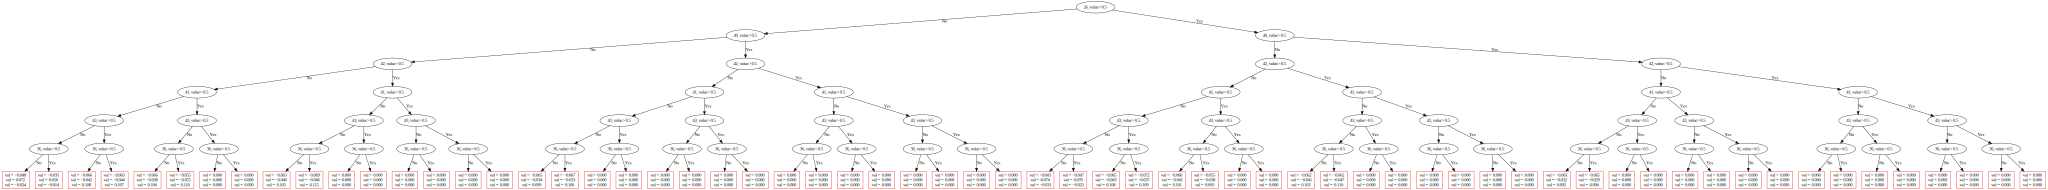

In [83]:
cat_pred.plot_tree(tree_idx = 1, pool=None)